# Step 1: Self-Supervised Learning (The "No Labeling" Phase)

#### The Problem

You have a folder full of unlabeled images of cards (Voter IDs, Visiting Cards, Bank Cards, etc.). You don't know what they are, and you don't have time to label them.

#### The Self-Supervised Solution

We'll use a simple yet powerful technique called **Image Rotation Prediction**.

- **The "Fake" Label**: We'll take each image and rotate it by 0, 90, 180, or 270 degrees.
- **The "Pretext Task"**: We will create a model that has to predict the exact angle of rotation.
- **The "Unlabeled Learning"**: To solve this "fake" problem, the model can't just guess randomly. It has to learn the core features of the cards - like the text, the patterns, the logos, and the orientation of faces - to correctly predict if the image is upside down or sideways. In doing so, **it learns a powerful, generalized "understanding" of cards**.

### 1. Install Necessary Libraries

In [24]:
#!pip install Pillow torch torchvision

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import random

### 2. Data Collection

Unlike Supervised Learning, we have only a folder with bunch of images. So we need to define our Dataset to get into this Self-Supervised Phase.

And in the below step, we are doing

### 3. Data Understanding
### 4. Data Preparation



In [31]:
class CardRotationDataset(Dataset):
    def __init__(self, root_dir, image_size=(128, 128)):
        # We check if the folder exists to ensure the script doesn't fail.
        if not os.path.isdir(root_dir):
            raise FileNotFoundError(f"The folder '{root_dir}' does not exist. Please check the path.")
            
        self.root_dir = root_dir
        # Get a list of all image files (we assume they are png, jpg, or jpeg)
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) 
                            if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(self.image_paths) == 0:
            raise RuntimeError(f"No image files found in '{root_dir}'. Please ensure the folder contains images.")

        # --- THE FIX IS HERE! ---
        # We define a transform that resizes all images to a consistent size.
        self.transform = transforms.Compose([
            transforms.Resize(image_size), # This will resize every image to 128x128
            transforms.ToTensor()          # Then convert it to a PyTorch tensor
        ])
        
        # We also need to get the size for our model's linear layer
        # This will be [channels, height, width]
        self.image_size = image_size
        self.num_channels = 3 # Assuming RGB images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # This is the core of Self-Supervised Learning!
        rotation_angle = random.choice([0, 90, 180, 270])
        if rotation_angle == 0:
            label = 0
        elif rotation_angle == 90:
            image = image.rotate(90)
            label = 1
        elif rotation_angle == 180:
            image = image.rotate(180)
            label = 2
        else: # 270 degrees
            image = image.rotate(270)
            label = 3
            
        # Apply the transformation to resize and convert to a tensor
        image = self.transform(image)
        return image, label

### 5. Model Building

Here we are defining the Model Architecture

In [32]:
class SimpleCNN(nn.Module):
    def __init__(self, image_size=(128, 128)):
        super(SimpleCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Calculate the size of the flattened output to correctly define the Linear layer
        # This calculation assumes the input image is 128x128
        # (128 / 2 / 2) * (128 / 2 / 2) * 32_channels = 32 * 32 * 32
        flattened_size = (image_size[0] // 4) * (image_size[1] // 4) * 32
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 4) # 4 classes: 0, 90, 180, 270 degrees
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.classifier(features)
        return output

### 6. Model Training(Self-Supervised Training)

In [33]:
def train_self_supervised_model():
    
    data_folder = r"C:\Users\John Gabriel\Downloads\Data Science with Machine Learning Course Materials\Machine Learning\Types of ML\my_card_images" 
    
    # We define a consistent image size for all images to be resized to.
    target_image_size = (128, 128)
    
    try:
        dataset = CardRotationDataset(root_dir=data_folder, image_size=target_image_size)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
   
    except (FileNotFoundError, RuntimeError) as e:
        print(f"Error: {e}")
        return

    model = SimpleCNN(image_size=target_image_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\n--- Starting Self-Supervised Training on images in '{data_folder}' ---")
   
    for epoch in range(10): 
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader):.4f}")

    # Save ONLY the "brain" (the encoder part)
    torch.save(model.encoder.state_dict(), 'self_supervised_encoder.pth')
    print("\nTraining finished! Saved the powerful 'encoder' to 'self_supervised_encoder.pth'.")

#### Notes:

###### .pth Means - PyTorch Model Checkpoint File

**What it is:**
A file containing a serialized (pickled) dictionary of a PyTorch model's parameters, such as weights, biases, and optimizer states.

**What it's used for:**
* **Saving Trained Models**: To store the learned state of a model after training.
* **Loading Models**: To load a previously saved model to continue training or make predictions.

**How it's used:**
You can save a model's state dictionary using torch.save() and load it with torch.load().

In [34]:
# Run the self-supervised training
if __name__ == "__main__":
    train_self_supervised_model()


--- Starting Self-Supervised Training on images in 'C:\Users\John Gabriel\Downloads\Data Science with Machine Learning Course Materials\Machine Learning\Types of ML\my_card_images' ---
Epoch 1, Loss: 0.8768
Epoch 2, Loss: 0.2844
Epoch 3, Loss: 0.0293
Epoch 4, Loss: 0.0024
Epoch 5, Loss: 0.0005
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0001
Epoch 9, Loss: 0.0001
Epoch 10, Loss: 0.0001

Training finished! Saved the powerful 'encoder' to 'self_supervised_encoder.pth'.


### ===========================================================================

# Step 2: Supervised Learning (The "Fine-Tuning" Phase)

* This is the second and final part of the process we discussed. We have now completed the hard part—training a model to understand images without any labels.
* The next step is to use that **"brain"** to solve your specific problem: identifying which card is which. This is where our small, hand-labeled dataset comes in.

### Notes:

The below script we will now run, loads the self_supervised_encoder.pth file we just created, adds a small classification layer to it, and then trains this new part of the model using your labeled data.

#### So we need to:

Create your labeled dataset: In a new folder (e.g., labeled_cards), manually sort just a handful of your card images (maybe 5-10 of each type) into subfolders with their names. For example:

* labeled_cards/voter_id/ (put all your voter ID images here)
* labeled_cards/bank_card/ (put all your bank card images here)
* labeled_cards/visiting_card/ (put all your visiting card images here)

### 1. Import Necessary Libraries

In [35]:
import glob

**Glob** is used to search for file path names that match a specific pattern, using wildcard characters like * and ? . It helps in locating and handling multiple files based on their paths efficiently.

### 2. Data Collection

Here we define our Supervised Dataset and this class reads our manually sorted, labeled card images.

And here itself our next 

### 3. Data Understanding
### 4. Data Preparation

steps are done.

In [36]:
class LabeledCardDataset(Dataset):
    def __init__(self, root_dir, image_size=(128, 128)):
        self.root_dir = root_dir
       
        # Get the names of the classes (the folder names)
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        self.image_paths = []
        for cls_name in self.classes:
            cls_path = os.path.join(root_dir, cls_name)
            for img_name in glob.glob(os.path.join(cls_path, '*')):
                self.image_paths.append((img_name, self.class_to_idx[cls_name]))
        
        if len(self.image_paths) == 0:
            raise RuntimeError(f"No labeled images found in '{root_dir}'.")
        
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, label

### 5. Model Building

Here we Define the Full Model for **Finetuning**
##### And this model uses the pre-trained encoder and adds a new classification head.

In [37]:
class FullClassifier(nn.Module):
    def __init__(self, encoder_path, num_classes):
        super(FullClassifier, self).__init__()
        
        # --- IMPORTANT: Re-define the SimpleCNN class here to avoid import issues ---
        # This is a good practice to make the script standalone.
        class SimpleCNN_Encoder(nn.Module):
            def __init__(self):
                super(SimpleCNN_Encoder, self).__init__()
                self.encoder = nn.Sequential(
                    nn.Conv2d(3, 16, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(16, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2)
                )
            def forward(self, x):
                return self.encoder(x)

        # Load the pre-trained 'brain' from Part 1
        self.encoder = SimpleCNN_Encoder().encoder
        self.encoder.load_state_dict(torch.load(encoder_path))
        print("Pre-trained encoder (the 'brain') loaded successfully!")

        # Keep the encoder's weights frozen so we don't ruin its learned knowledge
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Add a new, simple classifier to the end
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128), # Must match the encoder's output size for 128x128 images
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.classifier(features)
        return output

### 6. Model Training &

### 8. Model Evaluation

Here Model Training is **Model FineTuning**

In [38]:
def finetune_supervised_model():
    # --- IMPORTANT: REPLACE "your_labeled_data_folder" WITH YOUR ACTUAL FOLDER NAME ---
    data_folder = r"C:\Users\John Gabriel\Downloads\Data Science with Machine Learning Course Materials\Machine Learning\Types of ML\cards_labeled_small"
    
    try:
        dataset = LabeledCardDataset(root_dir=data_folder)
        dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
    
    except RuntimeError as e:
        print(f"Error: {e}")
        return

    num_classes = len(dataset.classes)
    model = FullClassifier(encoder_path='self_supervised_encoder.pth', num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001) # ONLY optimize the new classifier!

    print(f"\n--- Starting Supervised Finetuning on {len(dataset)} labeled images ---")
    for epoch in range(20): # We can train for more epochs as the dataset is small
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader):.4f}")

    print("\nFinetuning finished! The model is now ready for card classification.")
    print(f"Final classes: {dataset.classes}")
    # You could save the final model here for later use
    torch.save(model.state_dict(), 'card_classifier.pth')

In [39]:
if __name__ == "__main__":
    finetune_supervised_model()

Pre-trained encoder (the 'brain') loaded successfully!

--- Starting Supervised Finetuning on 20 labeled images ---
Epoch 1, Loss: 2.7574
Epoch 2, Loss: 0.9082
Epoch 3, Loss: 0.6066
Epoch 4, Loss: 0.7057
Epoch 5, Loss: 0.7264
Epoch 6, Loss: 0.4151
Epoch 7, Loss: 0.5084
Epoch 8, Loss: 0.4047
Epoch 9, Loss: 0.3586
Epoch 10, Loss: 0.4168
Epoch 11, Loss: 0.4567
Epoch 12, Loss: 0.3818
Epoch 13, Loss: 0.4268
Epoch 14, Loss: 0.4368
Epoch 15, Loss: 0.4018
Epoch 16, Loss: 0.4430
Epoch 17, Loss: 0.4893
Epoch 18, Loss: 0.3469
Epoch 19, Loss: 0.3845
Epoch 20, Loss: 0.3723

Finetuning finished! The model is now ready for card classification.
Final classes: ['bank_card', 'id_card', 'visiting_card', 'voter_id']


### ===========================================================================

# Step 3: Supervised Learning for Prediction

### 7. Model Testing or Model Prediction

#### 7.1 Define the FullClassifier Model (Same as the training script)
###### We need this class definition to correctly load the saved model's structure.

In [40]:
class FullClassifier(nn.Module):
    def __init__(self, encoder_path, num_classes):
        super(FullClassifier, self).__init__()
        
        # Redefine the encoder class to be self-contained
        class SimpleCNN_Encoder(nn.Module):
            def __init__(self):
                super(SimpleCNN_Encoder, self).__init__()
                self.encoder = nn.Sequential(
                    nn.Conv2d(3, 16, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(16, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2)
                )
            def forward(self, x):
                return self.encoder(x)

        self.encoder = SimpleCNN_Encoder().encoder
        # Note: We don't load the state_dict for the encoder here,
        # as the full model's state_dict contains the weights for the entire network.
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.classifier(features)
        return output

#### 7.2. Create the Prediction Function

In [41]:
# ---  ---
def predict_image(model, image_path, classes):
    # Check if the image path is valid
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at '{image_path}'")
        return None

    # Define the same transformations used during training
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

    # Put the model in evaluation mode
    model.eval()

    # Make the prediction
    with torch.no_grad():
        output = model(image_tensor)
        # Get the predicted class index
        predicted_idx = torch.argmax(output).item()
        
    # Get the class name from the index
    predicted_class = classes[predicted_idx]
    
    return predicted_class

#### 7.3. Main Script Execution

In [44]:

if __name__ == "__main__":
    # --- IMPORTANT: Configure your paths and classes here ---
    # Path to your final trained model
    model_path = 'card_classifier.pth'
    
    # Path to the new image you want to predict
    # Change this to a real image file path on your computer.
    new_image_path = r'C:\Users\John Gabriel\Downloads\Data Science with Machine Learning Course Materials\Machine Learning\Types of ML\cards_labeled_small\b_0118.png'

    # The list of classes must be in the exact same order as they were during training.
    # The order is determined by the sorted list of folder names in your 'labeled_cards' folder.
    # Check your finetuning script's output to confirm the order.
    final_classes = ['bank_card', 'id_card', 'visiting_card', 'voter_id']
    
    num_classes = len(final_classes)

    # Load the trained model
    model = FullClassifier(encoder_path='self_supervised_encoder.pth', num_classes=num_classes)
    try:
        model.load_state_dict(torch.load(model_path))
        print("Final model loaded successfully!")
    except FileNotFoundError:
        print(f"Error: Model file '{model_path}' not found. Please check the path.")
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")
        
    # Make a prediction on the new image
    print(f"\nMaking a prediction for the image at: {new_image_path}")
    predicted_label = predict_image(model, new_image_path, final_classes)
    
    if predicted_label:
        print(f"\nThe model predicts this card is a: **{predicted_label}**")

Final model loaded successfully!

Making a prediction for the image at: C:\Users\John Gabriel\Downloads\Data Science with Machine Learning Course Materials\Machine Learning\Types of ML\cards_labeled_small\b_0118.png

The model predicts this card is a: **bank_card**


# GIVEAWAY: 

##### 8 Hours Work Script for FREE.

**Disclaimer:** 
Please do not ask to correct your error, incase if you have got. It's practically impossible. Please try for yourself and fix it on your own.

# Important Lesson

Learn the Fundamentals strong, so you should be able to DECODE the scripts and fix the bugs.

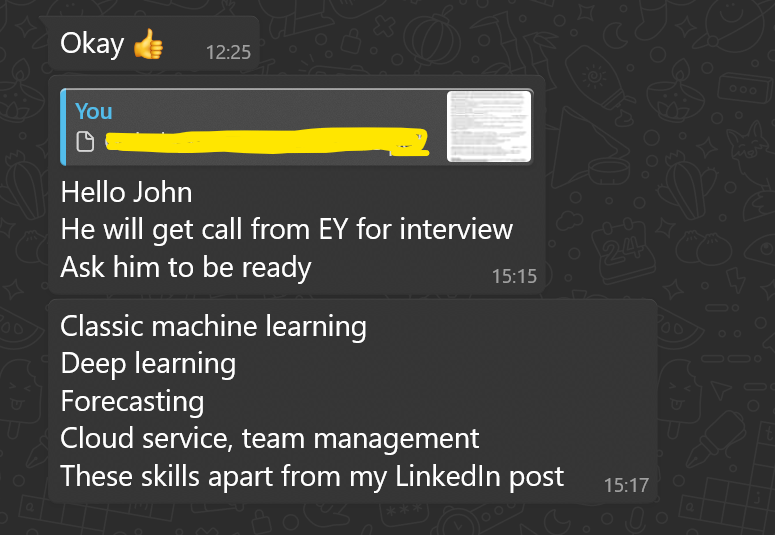